In [3]:
!pip install prophet
!pip install python-Levenshtein

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

USD/IDR Exchange Rate from Jan 2013 - May 2023

In [2]:
start_date = '2013-01-01'
# start_date_temp = '2008-07-01'

end_date = '2023-06-01'
# end_date_temp = '2009-07-01'

data_download = yf.download('USDIDR=X', start=start_date, end=end_date, progress=False)
data = data_download.drop(['Open',
                 'High',
                 'Low',
                 'Adj Close',
                 'Volume'],axis=1)

In [3]:
# extracting only the close values
values = pd.DataFrame(data['Close'])

# using shift function to shift the values.
dataframe = pd.concat([values.shift(i) for i in range(7, -2, -1)], axis=1)

# rename columns
dataframe.columns = [f't-{i}'for i in range(7, -2, -1)]
dataframe.columns = [i.replace('--', '+') for i in dataframe.columns]
dataframe.columns = [i.replace('t-0', 'Actual Close') for i in dataframe.columns]

# using shift function to shift the values.
dataframe = pd.concat([values.shift(i) for i in range(2, -2, -1)], axis=1)

# rename columns
dataframe.columns = ['t-2', 't-1', 'y', 't+1']

# remove NaN
dataframe = dataframe[2:]
dataframe = dataframe[:2710]

# reset index
dataframe.reset_index(inplace=True)
dataframe.columns = [i.replace('Date', 'ds') for i in dataframe.columns]

dataframe

,ds,t-2,t-1,y,t+1
0,2013-01-03,9609.000000,9609.000000,9622.500000,9626.299805
1,2013-01-04,9609.000000,9622.500000,9626.299805,9770.000000
2,2013-01-07,9622.500000,9626.299805,9770.000000,9639.099609
3,2013-01-08,9626.299805,9770.000000,9639.099609,9641.200195
4,2013-01-09,9770.000000,9639.099609,9641.200195,9632.099609
...,...,...,...,...,...
2705,2023-05-24,14918.000000,14886.000000,14895.000000,14945.900391
2706,2023-05-25,14886.000000,14895.000000,14945.900391,14970.000000
2707,2023-05-26,14895.000000,14945.900391,14970.000000,14948.000000
2708,2023-05-29,14945.900391,14970.000000,14948.000000,14960.000000


Split Data into 80/20

In [4]:
train = dataframe.iloc[:len(dataframe)-542]
test = dataframe.iloc[len(dataframe)-542:]

In [5]:
model = Prophet()
model.add_regressor('t-2',standardize=False)
model.add_regressor('t-1',standardize=False)
model.add_regressor('t+1',standardize=False)
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphea87ua5/bhjgibfo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphea87ua5/wipn1dxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76542', 'data', 'file=/tmp/tmphea87ua5/bhjgibfo.json', 'init=/tmp/tmphea87ua5/wipn1dxp.json', 'output', 'file=/tmp/tmphea87ua5/prophet_modelfth7dtvw/prophet_model-20230717085914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:59:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:59:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [6]:
forecast1 = model.predict(train)
forecast1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-03,9601.519311,10483.697944,13216.006637,9601.519311,9601.519311,2249.155812,2249.155812,2249.155812,2250.278706,...,13.411834,13.411834,13.411834,-14.534729,-14.534729,-14.534729,0.0,0.0,0.0,11850.675123
1,2013-01-04,9603.020917,10465.325921,13283.274771,9603.020917,9603.020917,2238.180648,2238.180648,2238.180648,2260.730757,...,13.596241,13.596241,13.596241,-36.146351,-36.146351,-36.146351,0.0,0.0,0.0,11841.201565
2,2013-01-07,9607.525734,10334.014688,13051.572584,9607.525734,9607.525734,2076.269587,2076.269587,2076.269587,2254.347470,...,-78.806641,-78.806641,-78.806641,-99.271243,-99.271243,-99.271243,0.0,0.0,0.0,11683.795320
3,2013-01-08,9609.027339,10425.770657,13147.174697,9609.027339,9609.027339,2200.126886,2200.126886,2200.126886,2289.875024,...,29.219815,29.219815,29.219815,-118.967953,-118.967953,-118.967953,0.0,0.0,0.0,11809.154225
4,2013-01-09,9610.528945,10316.941185,13035.415622,9610.528945,9610.528945,2112.238551,2112.238551,2112.238551,2247.810004,...,2.091453,2.091453,2.091453,-137.662907,-137.662907,-137.662907,0.0,0.0,0.0,11722.767496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163,2021-04-26,10622.469163,12408.467070,15269.845854,10622.469163,10622.469163,3197.703806,3197.703806,3197.703806,3414.767827,...,-78.806641,-78.806641,-78.806641,-138.257380,-138.257380,-138.257380,0.0,0.0,0.0,13820.172969
2164,2021-04-27,10623.000527,12502.600056,15379.968418,10623.000527,10623.000527,3290.149989,3290.149989,3290.149989,3392.892265,...,29.219815,29.219815,29.219815,-131.962091,-131.962091,-131.962091,0.0,0.0,0.0,13913.150516
2165,2021-04-28,10623.531891,12463.907813,15324.235835,10623.531891,10623.531891,3262.480658,3262.480658,3262.480658,3384.153611,...,2.091453,2.091453,2.091453,-123.764406,-123.764406,-123.764406,0.0,0.0,0.0,13886.012549
2166,2021-04-29,10624.063256,12557.454711,15340.098749,10624.063256,10624.063256,3297.674883,3297.674883,3297.674883,3398.041407,...,13.411834,13.411834,13.411834,-113.778359,-113.778359,-113.778359,0.0,0.0,0.0,13921.738138


In [7]:
forecast2 = model.predict(test)
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-03,10626.188713,12382.402594,15316.470382,10626.188713,10626.188713,3235.000308,3235.000308,3235.000308,3373.225924,...,-78.806641,-78.806641,-78.806641,-59.418975,-59.418975,-59.418975,0.0,0.0,0.0,13861.189021
1,2021-05-04,10626.720077,12601.498629,15337.703052,10626.720077,10626.720077,3367.842938,3367.842938,3367.842938,3381.962144,...,29.219815,29.219815,29.219815,-43.339021,-43.339021,-43.339021,0.0,0.0,0.0,13994.563015
2,2021-05-05,10627.251441,12602.050443,15468.210477,10627.251441,10627.251441,3343.623331,3343.623331,3343.623331,3368.313656,...,2.091453,2.091453,2.091453,-26.781778,-26.781778,-26.781778,0.0,0.0,0.0,13970.874773
3,2021-05-06,10627.782805,12670.351853,15337.589371,10627.782805,10627.782805,3389.149088,3389.149088,3389.149088,3385.765850,...,13.411834,13.411834,13.411834,-10.028596,-10.028596,-10.028596,0.0,0.0,0.0,14016.931894
4,2021-05-07,10628.314170,12689.562460,15411.459473,10628.314170,10628.314170,3379.814250,3379.814250,3379.814250,3359.582282,...,13.596241,13.596241,13.596241,6.635726,6.635726,6.635726,0.0,0.0,0.0,14008.128420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,2023-05-24,11025.243278,13313.415840,16041.516118,10860.420792,11214.820885,3577.865881,3577.865881,3577.865881,3485.673535,...,2.091453,2.091453,2.091453,90.100893,90.100893,90.100893,0.0,0.0,0.0,14603.109159
538,2023-05-25,11025.774642,13212.971972,16094.263193,10860.189107,11216.017644,3585.178045,3585.178045,3585.178045,3491.130676,...,13.411834,13.411834,13.411834,80.635536,80.635536,80.635536,0.0,0.0,0.0,14610.952687
539,2023-05-26,11026.306006,13204.345716,16021.355352,10860.061867,11217.214403,3585.849721,3585.849721,3585.849721,3502.104854,...,13.596241,13.596241,13.596241,70.148626,70.148626,70.148626,0.0,0.0,0.0,14612.155727
540,2023-05-29,11027.900099,13021.742773,15865.876256,10861.000056,11219.440740,3461.426581,3461.426581,3461.426581,3505.446290,...,-78.806641,-78.806641,-78.806641,34.786932,34.786932,34.786932,0.0,0.0,0.0,14489.326680


In [9]:
# calculate RMSE for fbprophet
score = np.sqrt(mean_squared_error(test['y'], forecast2['yhat']))
print('Score: %.2f RMSE' % (score))

# # calculate MSE for fbprophet
score = mean_squared_error(test['y'], forecast2['yhat'])
print('Score: %.2f MSE' % (score))

# # calculate MAE for fbprophet
score = mean_absolute_error(test['y'], forecast2['yhat'])
print('Score: %.2f MAE' % (score))

# # calculate R2 for fbprophet
score = r2_score(test['y'], forecast2['yhat'])
print('Score: %.2f R2' % (score))

Score: 552.79 RMSE
Score: 305573.61 MSE
Score: 468.88 MAE
Score: -0.50 R2


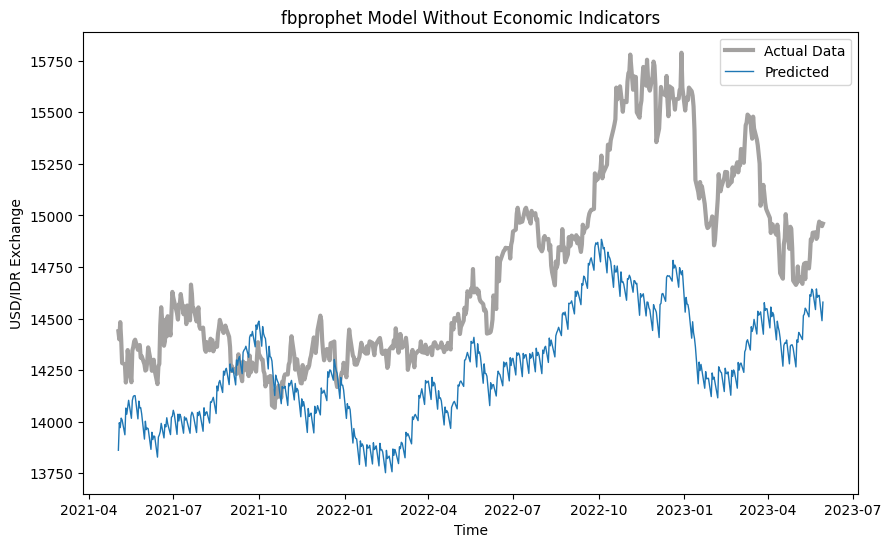

In [11]:
# create plot figure
plt.figure(figsize=(10,6))
plt.plot(test['ds'],test['y'],color="#a3a1a0",label='Actual Data',linewidth='3')
# plt.plot(forecast1['ds'],forecast1['yhat'],color='red',label='training',linewidth='0.5')
plt.plot(forecast2['ds'],forecast2['yhat'],label='Predicted',linewidth='1')
plt.title('fbprophet Model Without Economic Indicators')
plt.xlabel('Time')
plt.ylabel('USD/IDR Exchange')
plt.legend()
plt.show()

In [16]:
# Create a DataFrame to store predicted values
predicted_data = pd.DataFrame({'Date': forecast2['ds'], 'fbprophet': forecast2['yhat']})
# predicted_data
# Export predicted values to a CSV file
predicted_data.to_csv('fbprophet with no econ.csv', index=False)